### How to use **`exact_calculation()`**

In [1]:
import math
import numpy as np
import ffsim
from extended_matchgate_simulator.exact import exact_calculation
from extended_matchgate_simulator.utils import ucj_to_compatible
from qiskit.circuit import QuantumCircuit, QuantumRegister

#### We'll create a circuit that has 12 qubits and 16 controlled-phase gates. Our matchgates will be initialized randomly, but our controlled-phase gate angles will be sampled from  $\sim \mathcal{N}(\pi, .1)$. For exact calculations, our only concern is the number of controlled-phase gates, not the extent of the circuit.

In [2]:
mean, var = math.pi, .1
norb, nelec = 6, (3,3)

alpha_alpha_indices = [(p, p + 1) for p in range(norb - 1)]
alpha_beta_indices = [(p, p) for p in range(norb)]

qubits = QuantumRegister(2 * norb)
circuit = QuantumCircuit(qubits)
scale = math.sqrt(var)
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb,
                                                interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
                                                with_final_orbital_rotation=False,
                                                diag_coulomb_mean=mean,
                                                diag_coulomb_scale=scale,
                                                diag_coulomb_normal=True)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

#### We will run this helper function to 1) get rid of any unnecessary global phase gates and 2) make sure that the X gates described by the hartree_fock_jw gate remain at the beginning of the circuit. 

In [3]:
compatible = ucj_to_compatible(circuit)

#### Here is what the circuit looks like when it was been decomposed into just matchgates and controlled-phase gates.

Our circuit contains the following gates:
OrderedDict({'xx_plus_yy': 60, 'p': 24, 'cp': 16, 'x': 6})


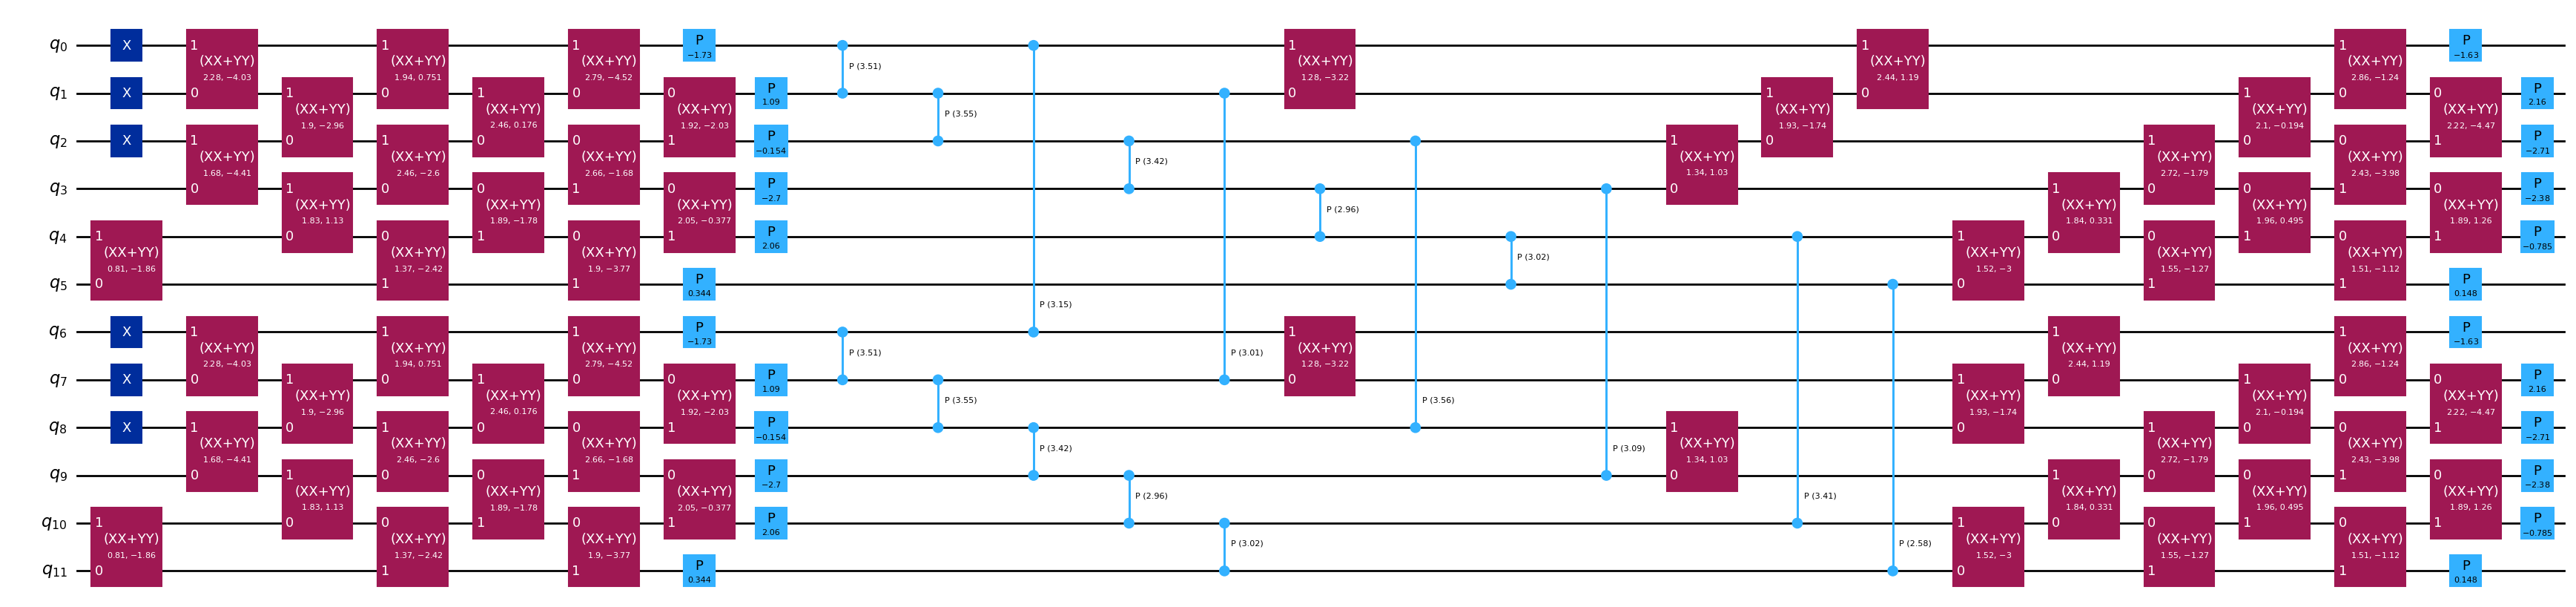

In [4]:
print("Our circuit contains the following gates:")
print(compatible.decompose(gates_to_decompose=['orb_rot_jw']).count_ops())
compatible.decompose(gates_to_decompose=['orb_rot_jw']).draw(fold=-1, output='mpl')

#### This circuit is small enough to be simulated by ffsim on a laptop, so we will use probabilities obtained from this library to validate the calculations obtained from our simulator.

In [5]:
statevec = ffsim.qiskit.final_state_vector(circuit)
ffsim_probs = np.abs(statevec.vec)**2
bitstrings = ffsim.addresses_to_strings(range(len(ffsim_probs)), norb, nelec)
print(f"There are {len(bitstrings)} bitstrings in the support of this circuit.")

There are 400 bitstrings in the support of this circuit.


#### Let's use **`exact_calculation()`** to calculate these probabilities and check the largest difference between our calculation ffsim's.

In [6]:
import numpy as np
probs = exact_calculation(circuit=compatible, outcome_states=bitstrings)
print("Largest difference between any of our exact calculations and ffsim's:", max(abs(probs - ffsim_probs)))

Largest difference between any of our exact calculations and ffsim's: 3.0531133177191805e-16
